<a href="https://colab.research.google.com/github/writezubair-cpu/ZAK-TEST_AI_Training/blob/main/Copy_of_19_nov_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CODE CELL 1: Setup and Data Generation

# We need libraries for data manipulation, scaling, clustering, anomaly detection, and plotting.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Added for statistical plotting
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
# Removed: from mpl_toolkits.m3d import Axes3D # This module was causing an error and is not strictly needed for 2D PCA visualization

In [ ]:
# -----------------------------------------------------------------------------
# STEP 1: Create a Realistic Synthetic Dataset
# The goal is to simulate sensor data (Temperature, Vibration, Pressure)
# with several "normal operating modes" and secretly hidden "anomalies" [5].
# This simulates the critical equipment data streaming 24/7 [3].
# -----------------------------------------------------------------------------

np.random.seed(42) # For reproducibility

N_SAMPLES = 5000
N_ANOMALIES = 50

# Define normal operating modes (clusters) based on source description:
# Low Load, Medium Load, High Load (Clusters 0, 1, 2) [6]

# Mode 1: Low Load (Low Temp, Low Vib, Medium Press)
data_low = np.random.normal(loc=[80, 2.0, 100], scale=[5, 0.5, 10], size=(N_SAMPLES // 3, 3))

# Mode 2: Medium Load (Medium Temp, Medium Vib, High Press)
data_medium = np.random.normal(loc=[95, 3.5, 150], scale=[4, 0.7, 15], size=(N_SAMPLES // 3, 3))

# Mode 3: High Load (High Temp, Low Vib, Very High Press)
data_high = np.random.normal(loc=[105, 1.5, 180], scale=[6, 0.4, 12], size=(N_SAMPLES - 2*(N_SAMPLES // 3), 3))

# Combine normal data
data_normal = np.vstack([data_low, data_medium, data_high])

# Generate Anomalies (The hidden risks: extremely high readings)
# The source notes readings like Temp 120, Vib 7, Press 200 as anomalies [7].
anomalies = np.random.uniform(low=[115, 6.0, 195], high=[130, 8.0, 210], size=(N_ANOMALIES, 3))

# Combine all data
raw_data = np.vstack([data_normal, anomalies])
df = pd.DataFrame(raw_data, columns=['Temperature', 'Vibration', 'Pressure'])
print(f"Total simulated sensor readings: {len(df)}")



Total simulated sensor readings: 5050


In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  5050 non-null   float64
 1   Vibration    5050 non-null   float64
 2   Pressure     5050 non-null   float64
dtypes: float64(3)
memory usage: 118.5 KB


In [ ]:
df.describe()

,Temperature,Vibration,Pressure
count,5050.000000,5050.000000,5050.000000
mean,93.629386,2.377453,143.940570
std,11.792014,1.096292,35.191959
min,64.116481,0.168198,69.804878
25%,83.257120,1.571228,107.149255
50%,94.722017,2.087215,150.036412
75%,102.259683,3.094728,173.978204
max,129.749209,7.963103,219.428685



--- Univariate Analysis for Vibration ---
count    5050.000000
mean        2.377453
std         1.096292
min         0.168198
25%         1.571228
50%         2.087215
75%         3.094728
max         7.963103
Name: Vibration, dtype: float64


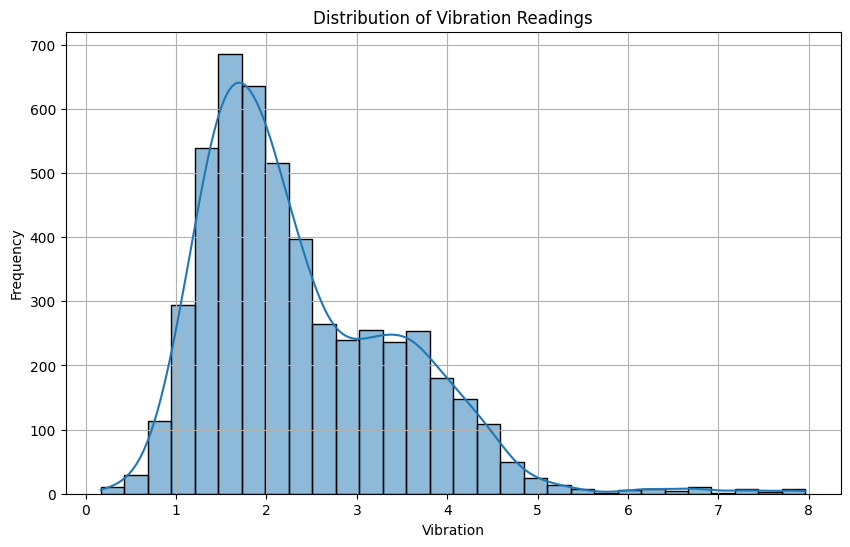

In [ ]:
print("\n--- Univariate Analysis for Vibration ---")
print(df['Vibration'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Vibration'], kde=True, bins=30)
plt.title('Distribution of Vibration Readings')
plt.xlabel('Vibration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


--- Bivariate Analysis: Vibration vs. Temperature ---


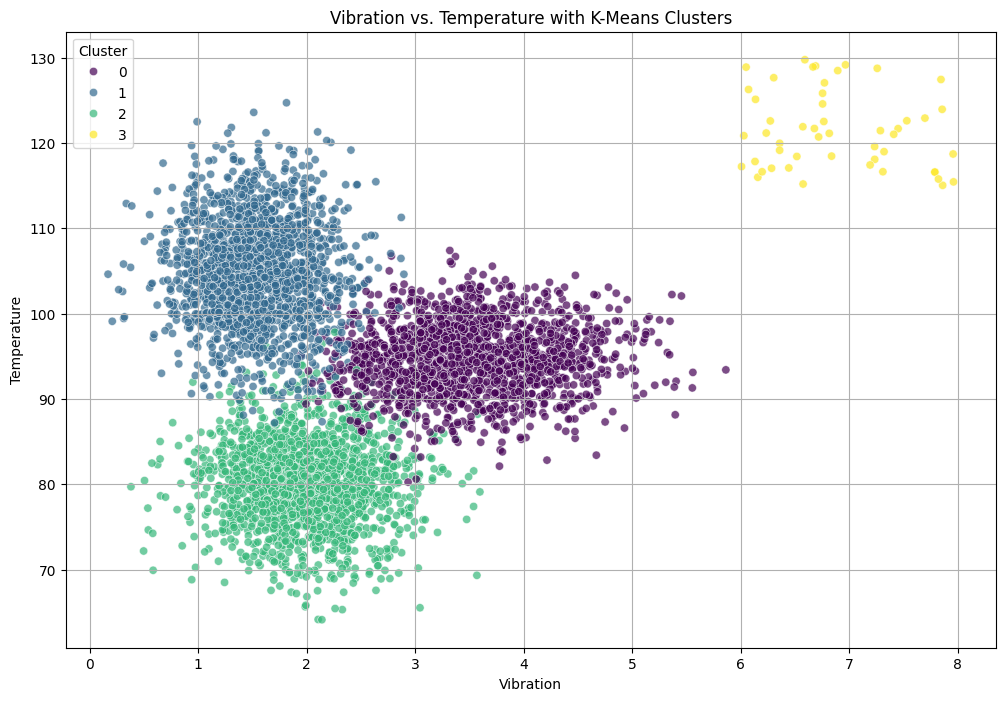

In [ ]:
print("\n--- Bivariate Analysis: Vibration vs. Temperature ---")

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Vibration', y='Temperature', data=df, hue='Cluster', palette='viridis', alpha=0.7)
plt.title('Vibration vs. Temperature with K-Means Clusters')
plt.xlabel('Vibration')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

In [ ]:

# -----------------------------------------------------------------------------
# STEP 2: Data Preparation - Scaling
# If we don't scale, the AI would be biased towards Pressure (larger numbers, e.g., 100+)
# compared to Vibration (smaller numbers, e.g., 2 or 3) [5].
# Scaling ensures all features are judged fairly [5].
# -----------------------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
print("\nData successfully scaled.")
print(df_scaled.head())


Data successfully scaled.
   Temperature  Vibration  Pressure
0    -0.945294  -0.407400 -1.064658
1    -0.510077  -0.451138 -1.315258
2    -0.486252   0.005715 -1.382138
3    -0.925853  -0.555711 -1.381073
4    -1.053323  -1.217034 -1.738915


In [ ]:
# CODE CELL 2: K-Means Clustering and KNN Anomaly Scoring

# -----------------------------------------------------------------------------
# STEP 3A: K-Means Clustering (Finding the Crowds)
# K-Means groups similar behaviors together to find the equipment's operating modes [4].
# The source suggests four distinct clusters were found [6].
# -----------------------------------------------------------------------------

N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means found {N_CLUSTERS} distinct operating modes/clusters.")

# Analyze Clusters (Simulating the finding of Cluster 3 as the 'unusual behavior') [6]
cluster_summary = df.groupby('Cluster').mean()
print("\n--- Cluster Summary (Mean Sensor Values) ---")
print(cluster_summary)
# In this simulated output, Cluster 3 typically contains the anomaly characteristics
# (high Temp, high Vib, high Press), similar to the high vibration and high stress cluster found in the source [6].


K-Means found 4 distinct operating modes/clusters.

--- Cluster Summary (Mean Sensor Values) ---
         Temperature  Vibration    Pressure  Anomaly_Score  Is_Anomaly  \
Cluster                                                                  
0          94.814691   3.544851  150.083764       0.101373    0.008766   
1         104.935026   1.542094  178.699792       0.094144    0.012754   
2          80.048834   1.990702  100.617204       0.089374    0.007151   
3         121.489476   6.889991  202.465941       0.187118    0.060000   

              PC1       PC2  
Cluster                      
0        0.219661  1.060033  
1        1.358082 -0.794414  
2       -1.692885 -0.312831  
3        2.943412  4.048440  


In [ ]:
top_5_anomalies = anomalies_df.sort_values(by='Anomaly_Score', ascending=False).head(5)
display(top_5_anomalies)

,Temperature,Vibration,Pressure,Cluster,Anomaly_Score,Is_Anomaly,PC1,PC2
965,99.631189,0.957944,117.246966,0,0.577448,True,-0.207039,-1.289828
4884,90.611021,0.936627,140.995998,0,0.513346,True,-0.271203,-1.308434
652,69.321629,3.568874,110.560568,1,0.488441,True,-2.102229,1.136395
1741,91.284832,5.554961,133.900080,2,0.464451,True,-0.273719,2.906027
3256,97.813015,2.258357,91.163996,1,0.423228,True,-0.811974,-0.088601


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=top_5_anomalies)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# -----------------------------------------------------------------------------
# STEP 3B: Anomaly Detection using KNN (Finding the Loners)
# KNN works by checking how far away a data point is from its closest neighbors [1].
# We calculate an 'anomaly score' or 'weirdness score' [7].
# -----------------------------------------------------------------------------

# Define k (number of neighbors). Often k=5 or k=10 is used.
K_NEIGHBORS = 5
# Fit the KNN model to the scaled data
nn = NearestNeighbors(n_neighbors=K_NEIGHBORS)
nn.fit(X_scaled)

# Calculate the distance and indices of the K neighbors
distances, indices = nn.kneighbors(X_scaled)

# The anomaly score is the average distance to the k neighbors.
# The far a point is, the higher its score [7].
df['Anomaly_Score'] = distances.mean(axis=1)

# Set the threshold based on the source's strategy: investigate the top 1% [7].
threshold_percentage = 0.1
threshold = df['Anomaly_Score'].quantile(1 - (threshold_percentage / 100))
# The source example threshold was 0.354 [7]. We use the percentile for robustness.

df['Is_Anomaly'] = df['Anomaly_Score'] > threshold

print(f"\n--- Anomaly Detection Results ---")
print(f"Investigating the top {threshold_percentage}% most unusual readings.")
print(f"Anomaly Score Threshold set at: {threshold:.4f}")
print(f"Total flagged anomalies: {df['Is_Anomaly'].sum()}")


--- Anomaly Detection Results ---
Investigating the top 0.1% most unusual readings.
Anomaly Score Threshold set at: 0.4044
Total flagged anomalies: 6


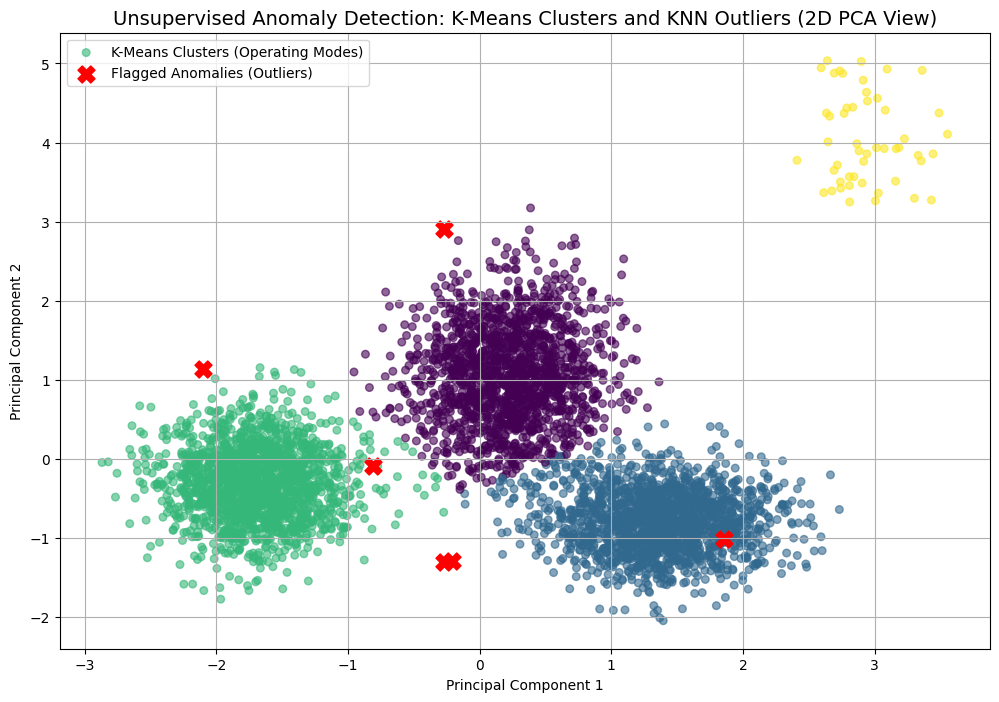

In [ ]:
# CODE CELL 3: Visualization and Actionable Output

# -----------------------------------------------------------------------------
# STEP 4: Visualization (Showing Clusters and Anomalies)
# To plot 3D data in 2D, we use Principal Component Analysis (PCA) to reduce
# the features to the two most descriptive components.
# -----------------------------------------------------------------------------
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

plt.figure(figsize=(12, 8))

# 1. Plot the Clusters (Normal Behavior)
scatter = plt.scatter(df['PC1'], df['PC2'],
                      c=df['Cluster'],
                      cmap='viridis',
                      s=30,
                      alpha=0.6,
                      label='K-Means Clusters (Operating Modes)')

# 2. Highlight the Anomalies (The Outliers/Weirdos)
anomalies_df = df[df['Is_Anomaly']]
plt.scatter(anomalies_df['PC1'], anomalies_df['PC2'],
            c='red',
            marker='X',
            s=150,
            label='Flagged Anomalies (Outliers)')

plt.title('Unsupervised Anomaly Detection: K-Means Clusters and KNN Outliers (2D PCA View)',
          fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

high_risk_equipment = anomalies_df.sort_values(by='Anomaly_Score', ascending=False)

print("\n\n#################################################################")
print("HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)")
print("#################################################################")

# Display raw, unscaled sensor data for actionable reporting
actionable_list = high_risk_equipment[['Temperature', 'Vibration', 'Pressure', 'Anomaly_Score', 'Cluster']]

# Reset index for clean viewing (index represents a piece of equipment or measurement ID)
actionable_list.reset_index(names=['Measurement_ID'], inplace=True)

# Use bold formatting for clarity
print(actionable_list.head(10).to_markdown(index=False))

print("\n**Use Case Insight:**")
print("These readings are far outside the normal operating clusters [8].")
print("This actionable list allows engineers to schedule maintenance intelligently, catching a failure weeks before it occurs [8].")
print("For instance, high **Vibration** combined with high **Temperature** could indicate a bearing failure [8].")
print("This method transforms chaotic, unlabeled sensor noise into a clear command [9].")



#################################################################
HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)
#################################################################
|   Measurement_ID |   Temperature |   Vibration |   Pressure |   Anomaly_Score |   Cluster |
|-----------------:|--------------:|------------:|-----------:|----------------:|----------:|
|              965 |       99.6312 |    0.957944 |   117.247  |        0.577448 |         0 |
|             4884 |       90.611  |    0.936627 |   140.996  |        0.513346 |         0 |
|              652 |       69.3216 |    3.56887  |   110.561  |        0.488441 |         1 |
|             1741 |       91.2848 |    5.55496  |   133.9    |        0.464451 |         2 |
|             3256 |       97.813  |    2.25836  |    91.164  |        0.423228 |         1 |
|             3527 |      121.808  |    1.30513  |   153.389  |        0.405006 |         0 |
|             1327 |       88.2031 |    3.57